This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Example for georeferencing a radar dataset

In [1]:
import wradlib.georef as georef
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.patches import Rectangle
import warnings

warnings.filterwarnings("ignore")
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()

/home/runner/micromamba-root/envs/wradlib-notebooks/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1st step:** Compute centroid coordinates and vertices of all radar bins in WGS84 (longitude and latitude).

In [2]:
# Define the polar coordinates and the site coordinates in lat/lon
r = np.arange(1, 129) * 1000
az = np.linspace(0, 360, 361)[0:-1]

# Site coordinates for different DWD radar locations (you choose)
# LAT:  drs:  51.12527778 ; fbg: 47.87444444 ; tur: 48.58611111 ; # muc: 48.3372222
# LON:  drs:  13.76972222 ; fbg: 8.005 ; tur: 9.783888889 ; muc: 11.61277778
sitecoords = (9.7839, 48.5861)

We can now generate the polgon vertices of the radar bins - with **each vertex in lon/lat coordinates**.

In [3]:
proj_wgs84 = georef.epsg_to_osr(4326)
polygons = georef.spherical_to_polyvert(r, az, 0, sitecoords, proj=proj_wgs84)
polygons = polygons[..., 0:2]
polygons.shape

(46080, 5, 2)

... or we can compute the corresponding centroids of all bins -  - with **each centroid in lon/lat coordinates**.

In [4]:
cent_coords = georef.spherical_to_centroids(r, az, 0, sitecoords, proj=proj_wgs84)
cent_coords = np.squeeze(cent_coords)
cent_lon = cent_coords[..., 0]
cent_lat = cent_coords[..., 1]

In order to understand how vertices and centroids correspond, we can plot them together.

(48.8361, 48.96877939454404)

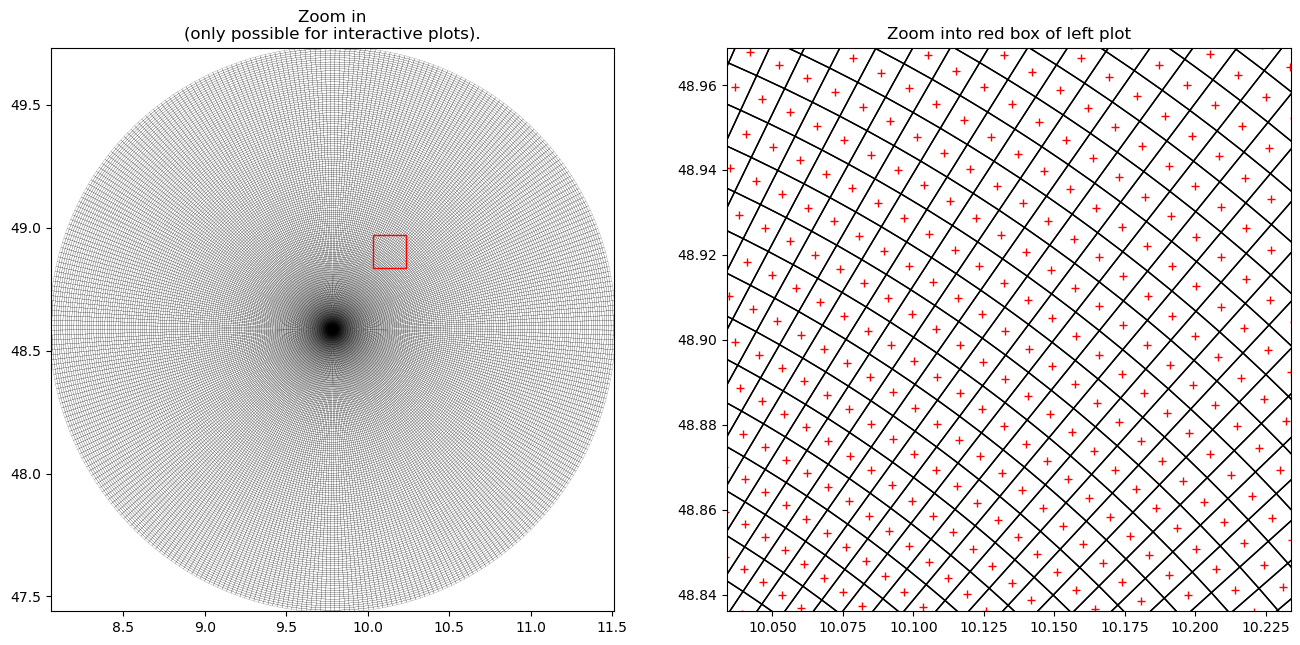

In [5]:
fig = pl.figure(figsize=(16, 16))
aspect = (cent_lon.max() - cent_lon.min()) / (cent_lat.max() - cent_lat.min())
ax = fig.add_subplot(121, aspect=aspect)
polycoll = mpl.collections.PolyCollection(
    polygons, closed=True, facecolors="None", linewidth=0.1
)
ax.add_collection(polycoll, autolim=True)
# ax.plot(cent_lon, cent_lat, 'r+')
pl.title("Zoom in\n(only possible for interactive plots).")
ax.add_patch(
    Rectangle(
        (sitecoords[0] + 0.25, sitecoords[1] + 0.25),
        0.2,
        0.2 / aspect,
        edgecolor="red",
        facecolor="None",
        zorder=3,
    )
)
pl.xlim(cent_lon.min(), cent_lon.max())
pl.ylim(cent_lat.min(), cent_lat.max())

ax = fig.add_subplot(122, aspect=aspect)
polycoll = mpl.collections.PolyCollection(polygons, closed=True, facecolors="None")
ax.add_collection(polycoll, autolim=True)
ax.plot(cent_lon, cent_lat, "r+")
pl.title("Zoom into red box of left plot")
pl.xlim(sitecoords[0] + 0.25, sitecoords[0] + 0.25 + 0.2)
pl.ylim(sitecoords[1] + 0.25, sitecoords[1] + 0.25 + 0.2 / aspect)

**2nd step:** Reproject the centroid coordinates to Gauss-Krueger Zone 3 (i.e. EPSG-Code 31467).

In [6]:
proj_gk3 = georef.epsg_to_osr(31467)
x, y = georef.reproject(cent_lon, cent_lat, projection_targe=proj_gk3)